In [1]:
# Add description here
#
# *Note:* You can open this file as a notebook (JupyterLab: right-click on it in the side bar -> Open With -> Notebook)

In [2]:
# Uncomment the next two lines to enable auto reloading for imported modules
# %load_ext autoreload
# %autoreload 2
# For more info, see:
# https://docs.ploomber.io/en/latest/user-guide/faq_index.html#auto-reloading-code-in-jupyter

In [3]:
##NOTE necessary to ignore warnings for usable report.
import warnings
from pathlib import Path

from darts import TimeSeries

from darts.dataprocessing import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold, GridSearchCV

from hydro_timeseries.darts_utils import backtest_minute_data

warnings.filterwarnings("ignore")

import numpy as np
np.set_printoptions(precision=3)

import pandas as pd
from hydro_timeseries.plotting import *
from hydro_timeseries.util import *
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

# If this task has dependencies, declare them in the YAML spec and leave this
# as None
upstream = None

# This is a placeholder, leave it as None
product = None

In [4]:
# Parameters
random_seed = 1
valid_from = "2021-11-01"
plots_path = "/home/m/repo/hydro-power-prediction/plots"
upstream = {"run-tests": {"nb": "/home/m/repo/hydro-power-prediction/reports/run_tests.ipynb", "data": "/home/m/repo/hydro-power-prediction/products/data/data_raw_tested.csv"}}
product = {"nb": "/home/m/repo/hydro-power-prediction/reports/exploratory_target.ipynb"}


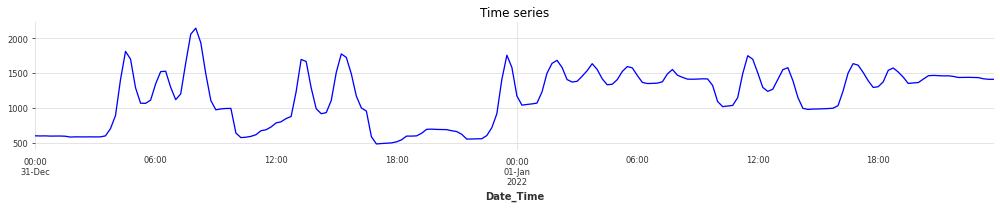

In [5]:
'''
Load data and split according to valid_from
Drop last two days
'''

data = load_timeseries_csv(upstream['run-tests']['data'])
data_daily = data.resample('D').mean()
data_hourly = data.resample('h').mean()

plots_path = Path(plots_path)
tsplot(data['2021-12-31':'2022-01-01']['Value'], do_plot_acf=False, filepath=plots_path / 'task_explanation.png')

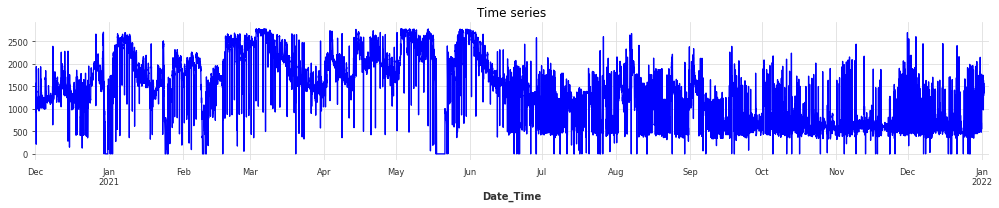

In [6]:
tsplot(data['Value'], do_plot_acf=False, filepath=plots_path / 'value.png')

In [7]:
# target is loaded daily.
train_until = pd.to_datetime(valid_from) - timedelta(days=1)
train = data[:train_until]
val = data[valid_from:]

# NOTE drop NaN Values for the last two days
val = val.dropna(axis = 0)

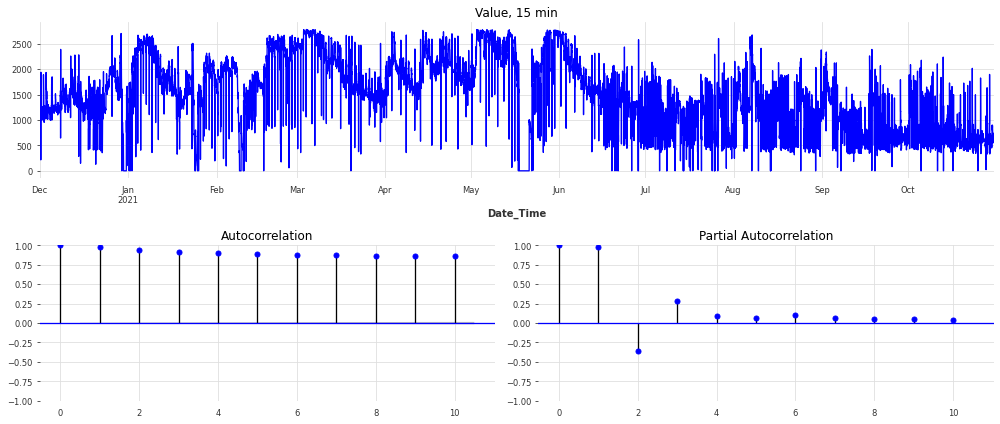

In [8]:
'''
Plot time series.
15 minute - too much variance
daily mean - doable.
'''

tsplot(train.Value, label = 'Value, 15 min')

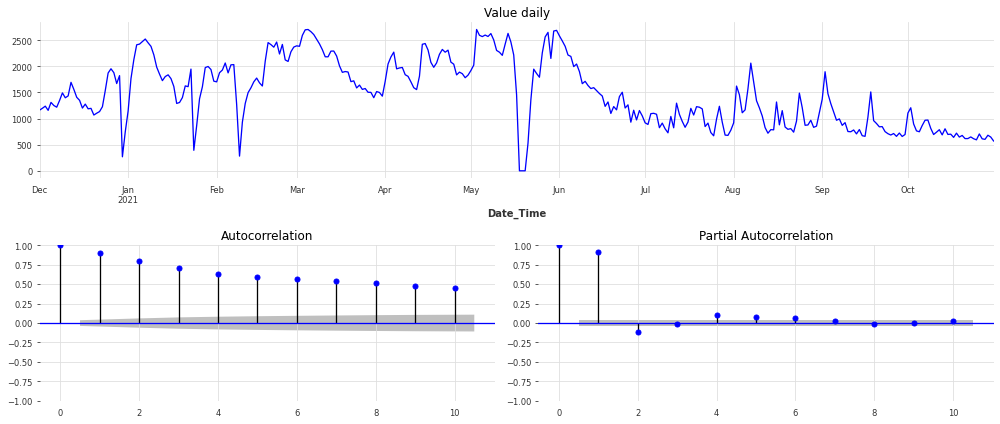

In [9]:
train_daily = data_daily[:train_until]
val_daily = data_daily[valid_from:]

tsplot(train_daily.Value, label = 'Value daily')

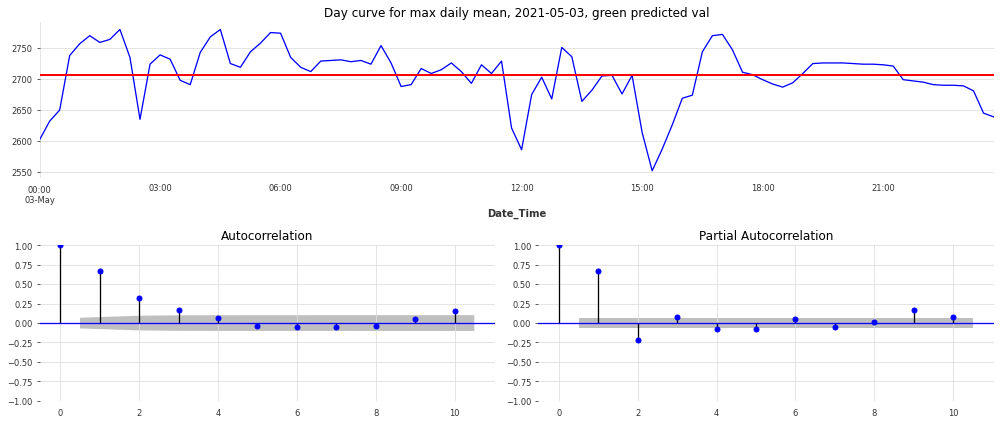

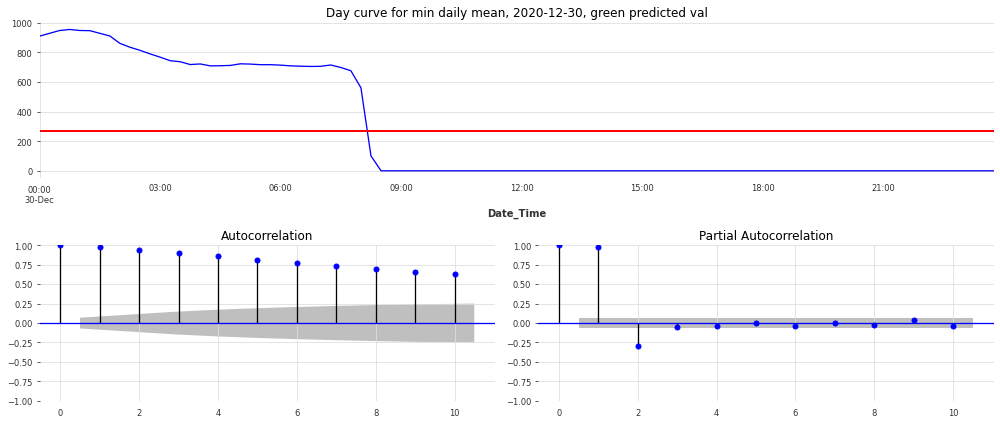

In [10]:
'''
Single day curve for max, min. 
True mean as a predictor
'''

train_daily_nonzero = train_daily[train_daily.Value != 0]
max_day = train_daily_nonzero.Value.idxmax().date()
min_day = train_daily_nonzero.Value.idxmin().date()
median_mean = train_daily_nonzero.Value.median()

max_day_pred = train[max_day.isoformat()].Value.copy()
max_day_mean = np.mean(train[max_day.isoformat()].Value)
max_day_pred[:] = max_day_mean

min_day_pred = train[min_day.isoformat()].Value.copy()
min_day_mean = np.mean(train[min_day.isoformat()].Value)
min_day_pred[:] = min_day_mean

tsplot(train[max_day.isoformat()].Value, y_pred=max_day_pred, label=f'Day curve for max daily mean, {max_day.isoformat()}, green predicted val')
tsplot(train[min_day.isoformat()].Value, y_pred=min_day_pred, label=f'Day curve for min daily mean, {min_day.isoformat()}, green predicted val')

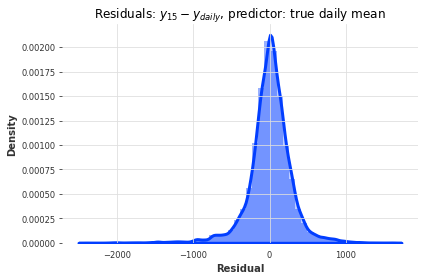

rmse_true_mean_daily = 288.3974064464307


In [11]:
'''
True Daily mean as a predictor 
- not bad 
- 288 kw error on average. 
'''

train['daily_true_mean'] = train.Value.resample('D').mean().reindex(train.index, method='ffill')
resid_true_mean = (train.Value - train.daily_true_mean).values

rmse_true_mean = np.sqrt(mean_squared_error(y_true=train.Value.values, y_pred=train.daily_true_mean.values))
plot_residuals(resid_true_mean, title='Residuals: $y_{15}-y_{daily}$, predictor: true daily mean')
print(f'rmse_true_mean_daily = {rmse_true_mean}')

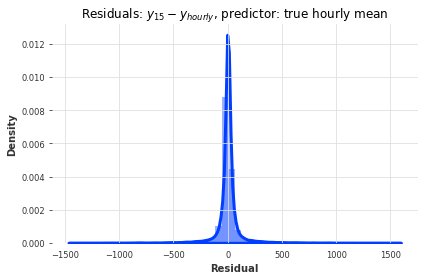

rmse_true_mean_hourly = 122.40585449890861


In [12]:
'''
True hourly mean: 
- rmse = 122 kw error
'''

train['hourly_true_mean'] = train.Value.resample('h').mean().reindex(train.index, method='ffill')
resid_true_mean = (train.Value - train.hourly_true_mean).values

rmse_true_mean = np.sqrt(mean_squared_error(y_true=train.Value.values, y_pred=train.hourly_true_mean.values))
plot_residuals(resid_true_mean, title='Residuals: $y_{15}-y_{hourly}$, predictor: true hourly mean')
print(f'rmse_true_mean_hourly = {rmse_true_mean}')

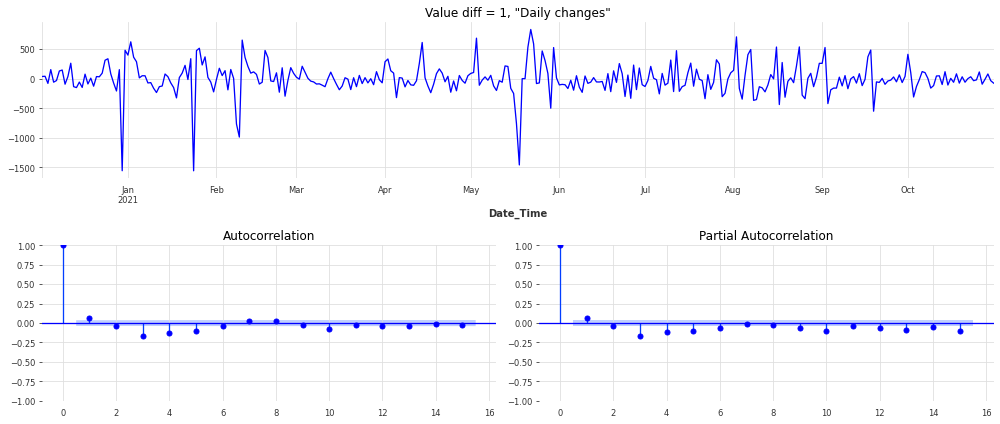

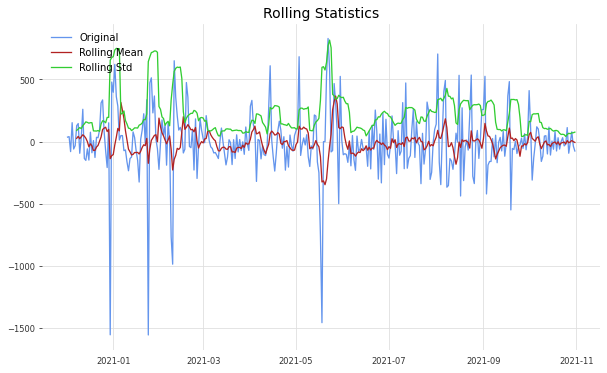

ADF Statistic: -10.572
p-value: 7.278277164940855e-19
##################################
Critical Values:
1%: -3.45
5%: -2.87
10%: -2.571
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.
Daily Value summary, mean=1482.7138370665423
count     335.000000
mean     1482.713837
std       631.504413
min         0.000000
25%       920.682292
50%      1434.500000
75%      1981.083333
max      2707.197917
Name: Value, dtype: float64
Daily Value changes summary
count     334.000000
mean       -1.768869
std       267.505571
min     -1555.781250
25%      -110.091146
50%       -10.083333
75%        93.377604
max       830.000000
Name: Value, dtype: float64


In [13]:
'''
# Simple differencing d=1, check for stationarity


## STATIONARITY 
A stationary time series is one whose properties do not depend on the time at which the series is observed.

Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

As well as looking at the time plot of the data, the ACF plot is also useful for identifying non-stationary time series. 
For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly. 
'''
daily_1diff = train_daily.Value.diff(1).dropna()
tsplot(daily_1diff, lags=15, label='Value diff = 1, "Daily changes"')

# 7 day window
adfuller_test(daily_1diff, window = 7)

print(f"Daily Value summary, mean={train_daily.Value.describe()['mean']}")
print(train_daily.Value.describe())

print("Daily Value changes summary")
# mean not in 0, slightly shifted.
print(daily_1diff.describe())

In [14]:
'''
Auto arma
'''
sm.tsa.arma_order_select_ic(daily_1diff.values, ic='bic', max_ar=3, max_ma=2)

{'bic':              0            1            2
 0  4692.017568  4696.036109  4701.808223
 1  4696.142688  4684.613313  4682.562382
 2  4701.327963  4680.645042  4685.171296
 3  4698.626010  4684.297258  4689.631981,
 'bic_min_order': (2, 1)}

In [15]:
'''
debug
'''
print(train_daily.Value.head())

print(train_daily.Value.tail())

Date_Time
2020-12-01    1161.843750
2020-12-02    1198.062500
2020-12-03    1238.145833
2020-12-04    1157.833333
2020-12-05    1310.260417
Freq: D, Name: Value, dtype: float64
Date_Time
2021-10-27    612.645833
2021-10-28    602.458333
2021-10-29    681.302083
2021-10-30    646.552083
2021-10-31    571.041667
Freq: D, Name: Value, dtype: float64


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  335
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2326.120
Date:                Wed, 24 Aug 2022   AIC                           4660.240
Time:                        11:44:45   BIC                           4675.485
Sample:                             0   HQIC                          4666.318
                                - 335                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9560      0.037     25.730      0.000       0.883       1.029
ar.L2         -0.1742      0.040     -4.387      0.000      -0.252      -0.096
ma.L1         -0.9516      0.032    -29.801      0.0

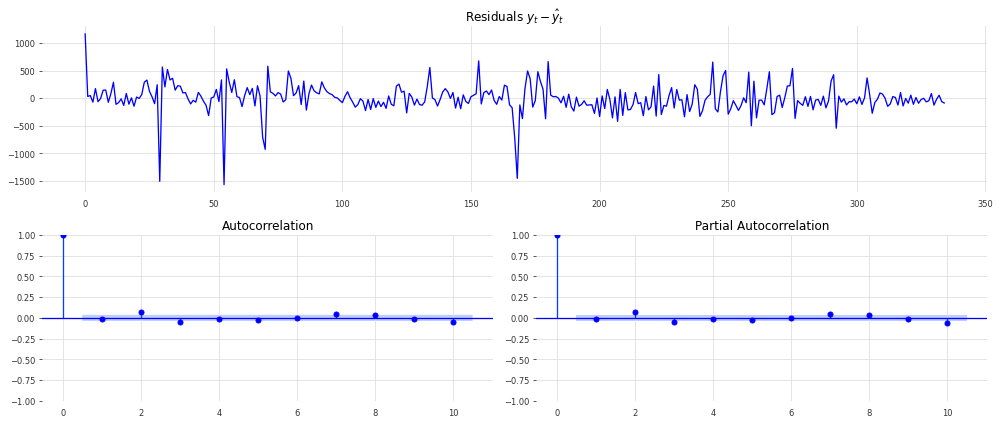

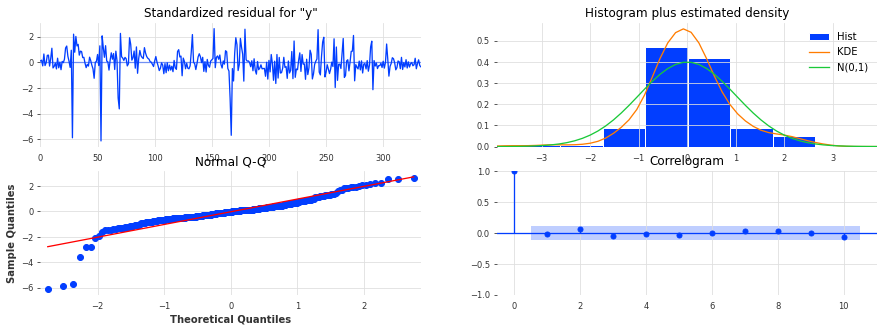

In [16]:
'''
arima (2,1,1)
AIC, BIC - the lower the better
'''


model = sm.tsa.arima.ARIMA(train_daily.Value.values, order=(2,1,1), trend=None).fit(start_params=[0, 0, 0, 1])
print(model.summary())

tsplot(model.resid, label = 'Residuals $y_t - \hat{y}_t$', filepath=plots_path / 'arima_daily_1step.png')


model.plot_diagnostics(figsize=(15,5))
plt.show()

In [17]:
# '''
# Auto arima confirms (2,1,1) for daily.
# '''
#

In [18]:
'''
ARIMA (2,1,1) rolling day ahead forecast
'''
from datetime import timedelta
from datetime import date

valid_from_dt = date.fromisoformat(valid_from)
all_means = data_daily.dropna(axis=0)
all_means['Date'] = all_means.index.date

val['arima_daily'] = -10000
val['Date'] = pd.to_datetime(val.index.date)
training_dates = [valid_from_dt - timedelta(days=1)]
for idx, val_date in enumerate(sorted(set(val.Date))):
    date_ahead = val_date + timedelta(days = 1)

    print(f'current day={val_date.date()} predicting day={date_ahead.date()} with last training date={training_dates[-1]}')
    day_ahead = val[val.Date == date_ahead]

    # for training only use D-1, D-2, D-3...
    training_df = all_means[all_means.Date <= training_dates[-1]]
    arima_daily = sm.tsa.arima.ARIMA(training_df.Value.values, order=(2, 1, 1), trend=None).fit()
    pred = arima_daily.forecast(steps = 2)
    day_ahead_arima = pred[1]

    # fill dataframe with day ahead arima mean prediction
    val.loc[val.Date == date_ahead, 'arima_daily'] = day_ahead_arima

    # make a one day step
    training_dates.append(val_date.date())

baseline_eval = val[val.arima_daily != -10000]
print("Value should not be -10000")
print(baseline_eval.iloc[0])

current day=2021-11-01 predicting day=2021-11-02 with last training date=2021-10-31
current day=2021-11-02 predicting day=2021-11-03 with last training date=2021-11-01


current day=2021-11-03 predicting day=2021-11-04 with last training date=2021-11-02
current day=2021-11-04 predicting day=2021-11-05 with last training date=2021-11-03


current day=2021-11-05 predicting day=2021-11-06 with last training date=2021-11-04
current day=2021-11-06 predicting day=2021-11-07 with last training date=2021-11-05


current day=2021-11-07 predicting day=2021-11-08 with last training date=2021-11-06
current day=2021-11-08 predicting day=2021-11-09 with last training date=2021-11-07


current day=2021-11-09 predicting day=2021-11-10 with last training date=2021-11-08
current day=2021-11-10 predicting day=2021-11-11 with last training date=2021-11-09


current day=2021-11-11 predicting day=2021-11-12 with last training date=2021-11-10
current day=2021-11-12 predicting day=2021-11-13 with last training date=2021-11-11


current day=2021-11-13 predicting day=2021-11-14 with last training date=2021-11-12
current day=2021-11-14 predicting day=2021-11-15 with last training date=2021-11-13


current day=2021-11-15 predicting day=2021-11-16 with last training date=2021-11-14
current day=2021-11-16 predicting day=2021-11-17 with last training date=2021-11-15


current day=2021-11-17 predicting day=2021-11-18 with last training date=2021-11-16
current day=2021-11-18 predicting day=2021-11-19 with last training date=2021-11-17


current day=2021-11-19 predicting day=2021-11-20 with last training date=2021-11-18
current day=2021-11-20 predicting day=2021-11-21 with last training date=2021-11-19


current day=2021-11-21 predicting day=2021-11-22 with last training date=2021-11-20
current day=2021-11-22 predicting day=2021-11-23 with last training date=2021-11-21


current day=2021-11-23 predicting day=2021-11-24 with last training date=2021-11-22
current day=2021-11-24 predicting day=2021-11-25 with last training date=2021-11-23


current day=2021-11-25 predicting day=2021-11-26 with last training date=2021-11-24
current day=2021-11-26 predicting day=2021-11-27 with last training date=2021-11-25


current day=2021-11-27 predicting day=2021-11-28 with last training date=2021-11-26
current day=2021-11-28 predicting day=2021-11-29 with last training date=2021-11-27


current day=2021-11-29 predicting day=2021-11-30 with last training date=2021-11-28
current day=2021-11-30 predicting day=2021-12-01 with last training date=2021-11-29


current day=2021-12-01 predicting day=2021-12-02 with last training date=2021-11-30
current day=2021-12-02 predicting day=2021-12-03 with last training date=2021-12-01


current day=2021-12-03 predicting day=2021-12-04 with last training date=2021-12-02
current day=2021-12-04 predicting day=2021-12-05 with last training date=2021-12-03


current day=2021-12-05 predicting day=2021-12-06 with last training date=2021-12-04
current day=2021-12-06 predicting day=2021-12-07 with last training date=2021-12-05


current day=2021-12-07 predicting day=2021-12-08 with last training date=2021-12-06
current day=2021-12-08 predicting day=2021-12-09 with last training date=2021-12-07


current day=2021-12-09 predicting day=2021-12-10 with last training date=2021-12-08
current day=2021-12-10 predicting day=2021-12-11 with last training date=2021-12-09


current day=2021-12-11 predicting day=2021-12-12 with last training date=2021-12-10
current day=2021-12-12 predicting day=2021-12-13 with last training date=2021-12-11


current day=2021-12-13 predicting day=2021-12-14 with last training date=2021-12-12
current day=2021-12-14 predicting day=2021-12-15 with last training date=2021-12-13


current day=2021-12-15 predicting day=2021-12-16 with last training date=2021-12-14
current day=2021-12-16 predicting day=2021-12-17 with last training date=2021-12-15


current day=2021-12-17 predicting day=2021-12-18 with last training date=2021-12-16
current day=2021-12-18 predicting day=2021-12-19 with last training date=2021-12-17


current day=2021-12-19 predicting day=2021-12-20 with last training date=2021-12-18
current day=2021-12-20 predicting day=2021-12-21 with last training date=2021-12-19


current day=2021-12-21 predicting day=2021-12-22 with last training date=2021-12-20
current day=2021-12-22 predicting day=2021-12-23 with last training date=2021-12-21


current day=2021-12-23 predicting day=2021-12-24 with last training date=2021-12-22
current day=2021-12-24 predicting day=2021-12-25 with last training date=2021-12-23


current day=2021-12-25 predicting day=2021-12-26 with last training date=2021-12-24
current day=2021-12-26 predicting day=2021-12-27 with last training date=2021-12-25


current day=2021-12-27 predicting day=2021-12-28 with last training date=2021-12-26
current day=2021-12-28 predicting day=2021-12-29 with last training date=2021-12-27


current day=2021-12-29 predicting day=2021-12-30 with last training date=2021-12-28
current day=2021-12-30 predicting day=2021-12-31 with last training date=2021-12-29


current day=2021-12-31 predicting day=2022-01-01 with last training date=2021-12-30
current day=2022-01-01 predicting day=2022-01-02 with last training date=2021-12-31


Value should not be -10000
Value                                      553.0
precip_20                                   0.09
precip_40                                    0.2
precip_75                                   0.28
precip_81                                   0.19
precip_104                                  0.09
precip_134                                  0.08
snow_depth_20                                0.0
snow_depth_40                                0.0
snow_depth_75                                0.0
snow_depth_81                                0.0
snow_depth_104                               0.0
snow_depth_134                               0.0
evapotranspiration_20                       1.37
evapotranspiration_40                       1.27
evapotranspiration_75                       0.92
evapotranspiration_81                       0.99
evapotranspiration_104                      0.89
evapotranspiration_134                      0.85
soil_moisture_index_20                    

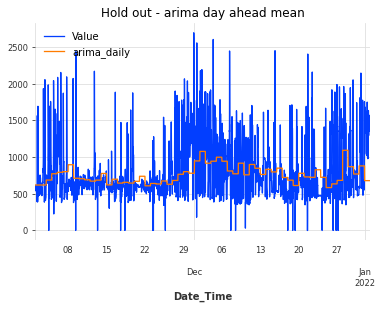

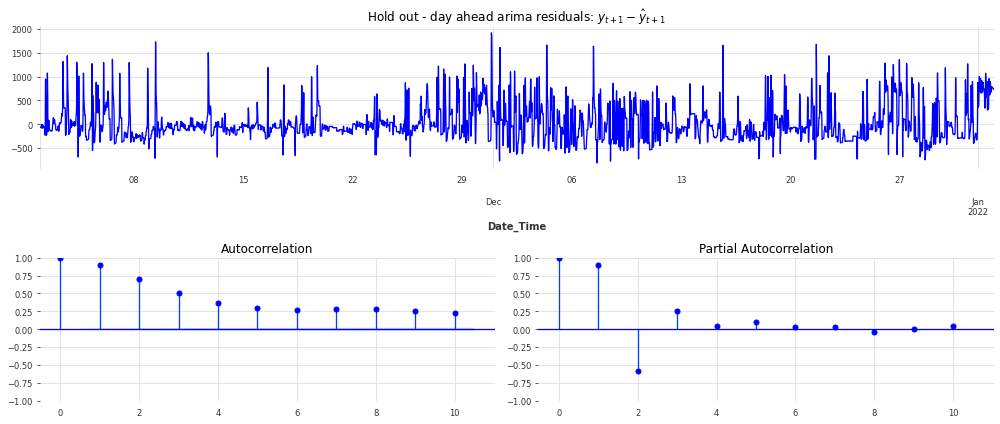

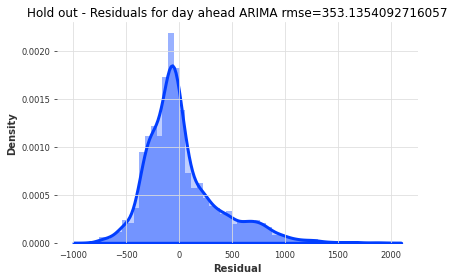

Baseline: Day ahead ARIMA(2,1,1) for two step prediction rmse=353.1354092716057 & smape=0.31344740822443773 on hold out


In [19]:
'''
Evaluation of baseline for two step prediction

rmse = 353 kw on average
'''
baseline_eval[['Value', 'arima_daily']].plot(title='Hold out - arima day ahead mean')
plt.show()
baseline_eval.loc[:, 'resid'] = baseline_eval.Value - baseline_eval.arima_daily
tsplot(baseline_eval.resid, label='Hold out - day ahead arima residuals: $y_{t+1} - \hat{y}_{t+1}$', filepath=plots_path / 'arima_daily_2step.png')
baseline_mse = np.sqrt(np.mean(baseline_eval.resid.values**2))

smape_hold_out = smape(baseline_eval.Value, baseline_eval.arima_daily)

plot_residuals(baseline_eval.resid.values, title=f'Hold out - Residuals for day ahead ARIMA rmse={baseline_mse}')
print(f"Baseline: Day ahead ARIMA(2,1,1) for two step prediction rmse={baseline_mse} & smape={smape_hold_out} on hold out")

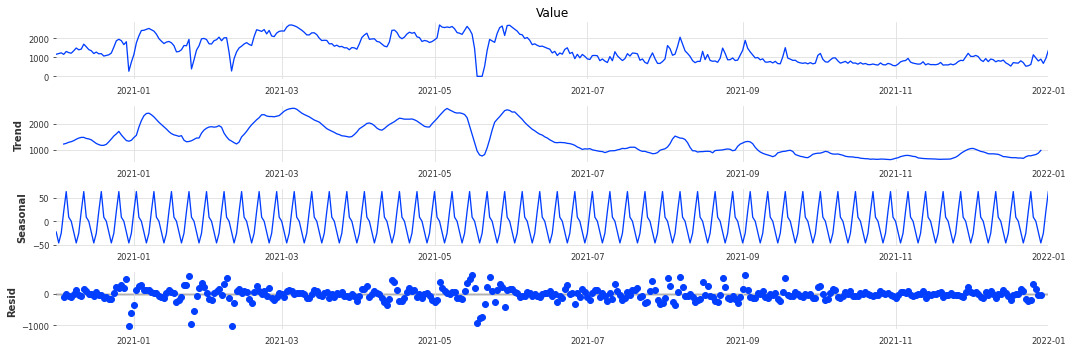

In [20]:
'''
Detrending and then explaining the seasonal + residual components using 
RF with cyclical variables + lagged residuals 
(NOTE: try longer trend: period = 30)
'''
# trend, seasonal, resid = seasonal_decompose_plot(data_daily.Value.dropna(axis=0), period=15)
trend, seasonal, resid = seasonal_decompose_plot(data_daily.Value.dropna(axis=0), period=7)
selector = ~trend.isna()
trend = trend[selector]
seasonal = seasonal[selector]
resid = resid[selector]

In [21]:
'''
(5,1,1) for trend period=30
(2,1,1) for trend if period not specified
'''

trend_arima = auto_arima(trend,
                          information_criterion='bic',
                          trace = True,
                          stepwise = True,
                          random_state=random_seed,
                          n_fits = 1000)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=4109.028, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=4531.585, Time=0.01 sec


 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=4137.083, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=4291.116, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=4525.643, Time=0.01 sec


 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=4131.098, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=4103.107, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=4133.083, Time=0.09 sec


 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=4129.074, Time=0.07 sec


 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=4109.025, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=4124.797, Time=0.10 sec


 ARIMA(3,1,2)(0,0,0)[0] intercept   : BIC=4110.340, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=4097.246, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=4127.117, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=4123.108, Time=0.04 sec


 ARIMA(3,1,1)(0,0,0)[0]             : BIC=4103.173, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : BIC=4103.176, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=4131.119, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=4125.131, Time=0.07 sec


 ARIMA(3,1,0)(0,0,0)[0]             : BIC=4118.831, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : BIC=4104.455, Time=0.18 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 2.112 seconds


                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                  391
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2036.691
Date:                Wed, 24 Aug 2022   AIC                           4081.381
Time:                        11:45:00   BIC                           4097.246
Sample:                    12-04-2020   HQIC                          4087.670
                         - 12-29-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7370      0.031     55.821      0.000       1.676       1.798
ar.L2         -0.8146      0.026    -31.902      0.000      -0.865      -0.765
ma.L1         -0.8903      0.040    -22.049      0.0

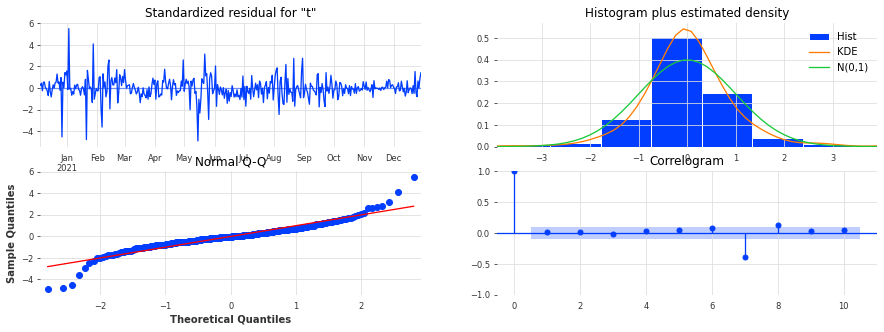

In [22]:
trend_arima = sm.tsa.arima.ARIMA(trend, order=(2,1,1), trend=None).fit()
print(trend_arima.summary())
trend_arima.plot_diagnostics(figsize=(15,5))
plt.show()

In [23]:
from darts.models import ARIMA
#RMSE=356.87 MAE=253.67
#arima = ARIMA(p=5, d=1, q=0, trend=None)>.fit(TimeSeries.from_series(train_daily['Value'].dropna()))

#RMSE=353.14 MAE=253.41
# arima = ARIMA(p=2, d=1, q=1, trend=None)

# arima = ARIMA(p=5, d=1, q=0, trend=None).fit(TimeSeries.from_series(train_daily['Value'].dropna()))
arima = ARIMA(p=2, d=1, q=1, trend=None).fit(TimeSeries.from_series(train_daily['Value'].dropna()))

  0%|          | 0/346 [00:00<?, ?it/s]

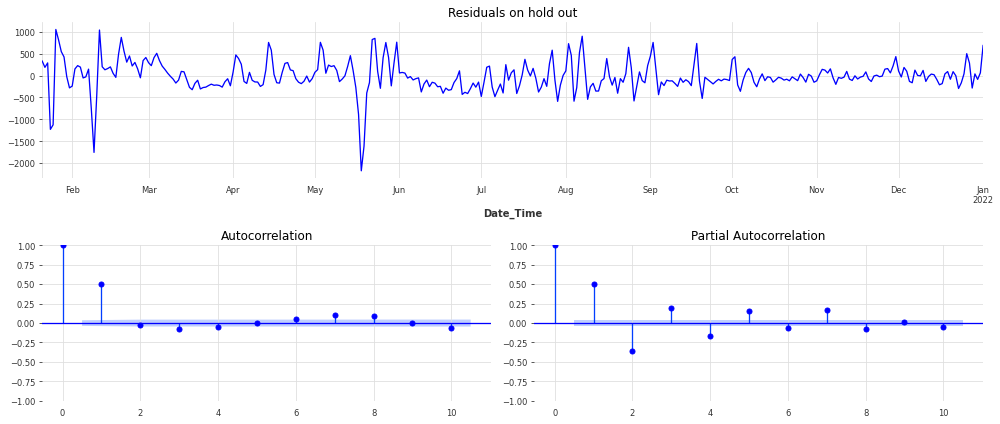

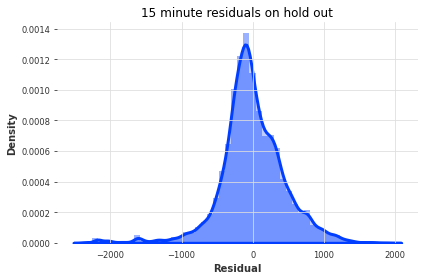

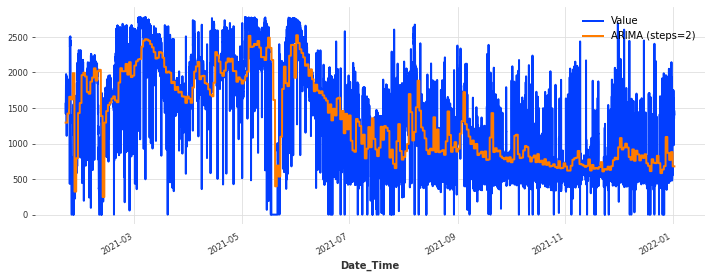

ARIMA n_val=33216 SMAPE=29.86 RMSE=458.17 MAE=328.79


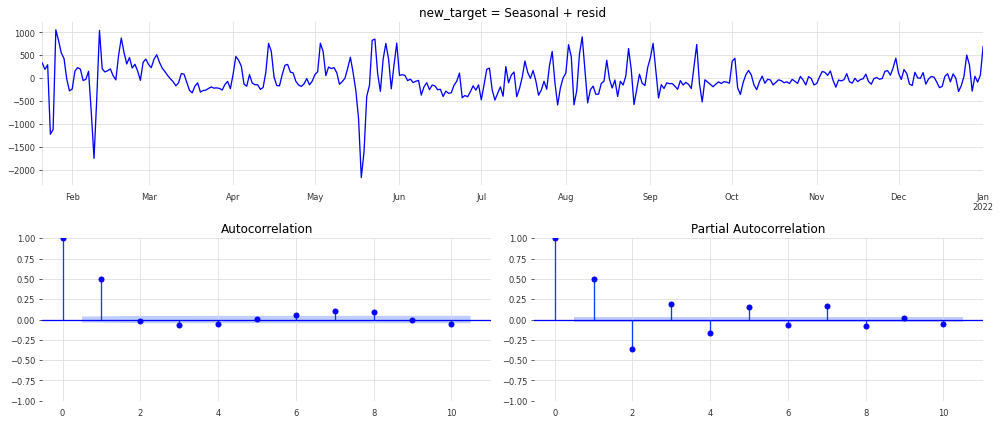

In [24]:
backtest, ts_eval, rmse, mae, mape = backtest_minute_data(arima,
                   TimeSeries.from_series(data_daily['Value'].dropna()),
                   data_df=data.dropna(), valid_from='2021-01-20',
                   forecast_horizon=2, retrain=True,
                   scaler=None)

bt_df = backtest.pd_dataframe()

arima_true_resid = (data_daily['Value'] - bt_df['Value']).dropna()
tsplot(arima_true_resid, label="new_target = Seasonal + resid")

In [25]:
new_daily = arima_true_resid.to_frame('target')
new_daily['resid_lag2']=arima_true_resid.shift(2)
new_daily['arima'] = bt_df['Value']
new_daily['Value'] = data_daily['Value']

In [26]:
new_daily = (
        new_daily
        # .assign(hour = data.index.hour)
        # .assign(day_of_month = data.index.day)
        .assign(month = new_daily.index.month)
        # .assign(day_of_week = data.index.dayofweek)
        .assign(day_of_year = new_daily.index.day_of_year)
        .assign(week_of_year = new_daily.index.week)
        )

new_daily = generate_cyclical_features(new_daily, 'month', 12, 1)
new_daily = generate_cyclical_features(new_daily, 'week_of_year', 53, 1)
new_daily = generate_cyclical_features(new_daily, 'day_of_year', 366, 1)

In [27]:
new_daily = new_daily.dropna()
print(new_daily.head())

                 target   resid_lag2        arima        Value  sin_month  \
2021-01-23   290.194569   331.988551  1658.117931  1948.312500        0.0   
2021-01-24 -1229.288305   188.814885  1621.819555   392.531250        0.0   
2021-01-25 -1124.978327   290.194569  1990.467910   865.489583        0.0   
2021-01-26  1054.899766 -1229.288305   323.985650  1378.885417        0.0   
2021-01-27   816.504242 -1124.978327   793.412425  1609.916667        0.0   

            cos_month  sin_week_of_year  cos_week_of_year  sin_day_of_year  \
2021-01-23        1.0          0.234886          0.972023         0.368763   
2021-01-24        1.0          0.234886          0.972023         0.384665   
2021-01-25        1.0          0.348202          0.937420         0.400454   
2021-01-26        1.0          0.348202          0.937420         0.416125   
2021-01-27        1.0          0.348202          0.937420         0.431673   

            cos_day_of_year  
2021-01-23         0.929523  
2021-01-

In [28]:

features = ['resid_lag2', 'sin_month', 'cos_month', 'sin_week_of_year',
       'cos_week_of_year', 'sin_day_of_year', 'cos_day_of_year']

X = new_daily[features][:pd.to_datetime(valid_from) - timedelta(days=1)]
y = new_daily['target'][:pd.to_datetime(valid_from) - timedelta(days=1)].values.ravel()

new_daily_test = new_daily[pd.to_datetime(valid_from):]

In [29]:
cv = RepeatedKFold(n_splits=4,n_repeats=2, random_state=random_seed)
rf = RandomForestRegressor(random_state=random_seed)

In [30]:
param_grid = {
    'n_estimators': list(range(50, 200, 20)),
    'max_features': [None, 'sqrt'],
    'max_depth' : [6, 7, 8, 10, 20, 30],
    'min_samples_split' : [4, 8, 16],
    'min_samples_leaf' : [4, 5, 6],
}

In [31]:
# CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=3, error_score="raise")
# CV_rf.fit(X, y)
# print(CV_rf.best_params_)
# print(CV_rf.best_score_)
#
# chosen_params = CV_rf.best_params_

In [32]:
chosen_params =\
    {'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 5,
     'min_samples_split': 4,
     'n_estimators': 150}

In [33]:
rf = RandomForestRegressor(**chosen_params)
rf.fit(X, y)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=4, n_estimators=150)

In [34]:
y_test_pred = rf.predict(new_daily_test[features]) + new_daily_test['arima']
new_daily_test['Value_pred'] = y_test_pred
arimarf_rmse_daily = np.mean(np.sqrt((new_daily_test['Value'] - new_daily_test['Value_pred'])**2))
arima_rmse_daily = np.mean(np.sqrt((new_daily_test['Value'] - new_daily_test['arima'])**2))


print(f'ARIMA + RF on DAILY RMSE={arimarf_rmse_daily}')
print(f'ARIMA on DAILY RMSE={arima_rmse_daily}')

ARIMA + RF on DAILY RMSE=124.99920881887893
ARIMA on DAILY RMSE=116.67273630224075


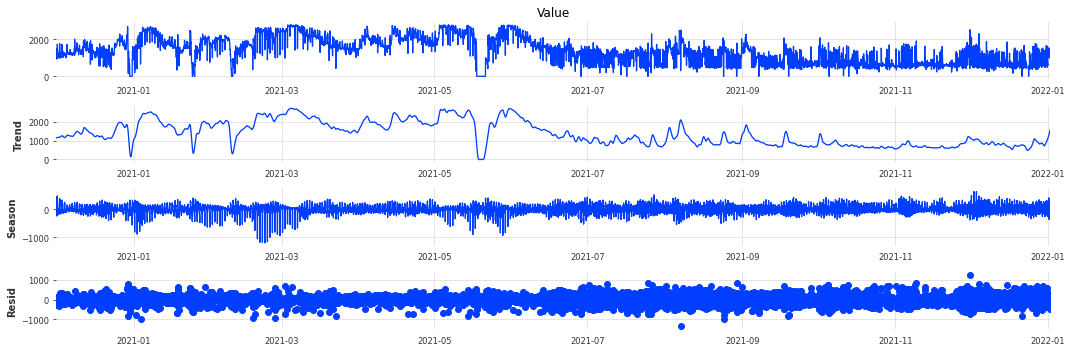

In [35]:
'''
IDEA: Hourly detrending instead of daily? - trend is almost daily mean.
Long ARIMA (5,1,0) ?
RNN to fit the hourly, 15 minute trend? 
'''
trend, seasonals, residuals = stl_decompose_plot(data_hourly.Value.dropna(), period=24)

In [36]:
'''
Best hourly arima (5,1,0) if max p = 5, huge ps when allowed higher. 
Model trend with some non linear models: RNN, TCN?
'''
hourly_trend_arima = auto_arima(trend.dropna(),
                          information_criterion='bic',
                          trace = True,
                          stepwise = True,
                          random_state=random_seed,
                          max_p=4,
                          max_d=2,
                          max_q=4,
                          n_fits = 100)

Performing stepwise search to minimize bic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=-10879.709, Time=6.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=72797.288, Time=0.15 sec


 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=inf, Time=0.50 sec


 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=72788.311, Time=0.08 sec


 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=6248.775, Time=2.80 sec


 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=-7134.078, Time=4.33 sec


 ARIMA(3,1,2)(0,0,0)[0] intercept   : BIC=-12086.065, Time=5.48 sec


 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=-10783.734, Time=7.74 sec


 ARIMA(4,1,2)(0,0,0)[0] intercept   : BIC=-11281.460, Time=10.70 sec


 ARIMA(3,1,3)(0,0,0)[0] intercept   : BIC=-12092.793, Time=5.31 sec


 ARIMA(2,1,3)(0,0,0)[0] intercept   : BIC=-11497.370, Time=7.83 sec


 ARIMA(4,1,3)(0,0,0)[0] intercept   : BIC=-12098.080, Time=15.87 sec


 ARIMA(4,1,4)(0,0,0)[0] intercept   : BIC=-12248.375, Time=23.42 sec


 ARIMA(3,1,4)(0,0,0)[0] intercept   : BIC=-12203.161, Time=23.68 sec


 ARIMA(4,1,4)(0,0,0)[0]             : BIC=-12257.515, Time=7.82 sec


 ARIMA(3,1,4)(0,0,0)[0]             : BIC=-12212.306, Time=5.38 sec


 ARIMA(4,1,3)(0,0,0)[0]             : BIC=-12111.837, Time=8.11 sec


 ARIMA(3,1,3)(0,0,0)[0]             : BIC=-12101.934, Time=2.45 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0]          
Total fit time: 140.138 seconds


In [37]:
# from statsmodels.tsa.seasonal import STL
#
# period = 96
# res = STL(train.Value, period=period*7).fit()
#
# # %%
# sns.set_palette(sns.color_palette("bright", 6))
# res.plot()
# plt.show()

In [38]:
'''
BIC (5,2,2)
'''

# minute_trend_arima = auto_arima(res.trend,
#                           information_criterion='aic',
#                           trace = True,
#                           stepwise = True,
#                           random_state=random_seed,
#                           max_p=5,
#                           max_d=2,
#                           max_q=5,
#                           n_fits = 1000)

'\nBIC (5,2,2)\n'